# Layer Decomposition and Reconstruction with Conditional Dilation


In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage.morphology import binary_dilation, binary_erosion, disk
from matplotlib.colors import ListedColormap
import os

## Configuration Parameters

In [2]:
# File paths
image_path = '../data/map.png'

# Morphological operation parameters
se_size = 3
dilation_iterations = 2

# Visualization parameters
figure_size = (15, 10)
cmap_layers = 'gray'
custom_colors = ['#fffea8', '#e59800', '#000000', '#fefefe', '#a7fefe']

# Binary layer colormap:
binary_colors = ['#ffffff', '#9c981e']
binary_cmap = ListedColormap(binary_colors)

## Load and Prepare Image

Image loaded:
- Dimensions: 492x520 pixels
- Intensity range: [0, 4]
- Unique intensity values: [0 1 2 3 4]
- Number of layers: 5


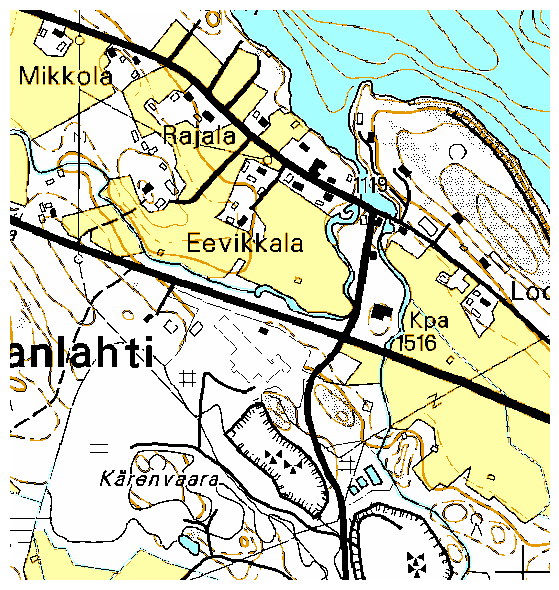

In [3]:
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at {image_path}")

original_image = np.array(Image.open(image_path))

if len(original_image.shape) == 3:
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
else:
    gray_image = original_image

height, width = gray_image.shape

unique_values = np.unique(gray_image)
num_layers = len(unique_values)

print(f"Image loaded:")
print(f"- Dimensions: {width}x{height} pixels")
print(f"- Intensity range: [{gray_image.min()}, {gray_image.max()}]")
print(f"- Unique intensity values: {unique_values}")
print(f"- Number of layers: {num_layers}")

color_list = custom_colors[:len(unique_values)]
custom_cmap = ListedColormap(color_list)

plt.figure(figsize=(8, 6))
plt.imshow(gray_image, cmap=custom_cmap, vmin=gray_image.min(), vmax=gray_image.max())
plt.axis('off')
plt.tight_layout()
plt.show()

## Step 1: Layer Extraction

Decompose the grayscale image into binary layers

Extracting 5 binary layers ...


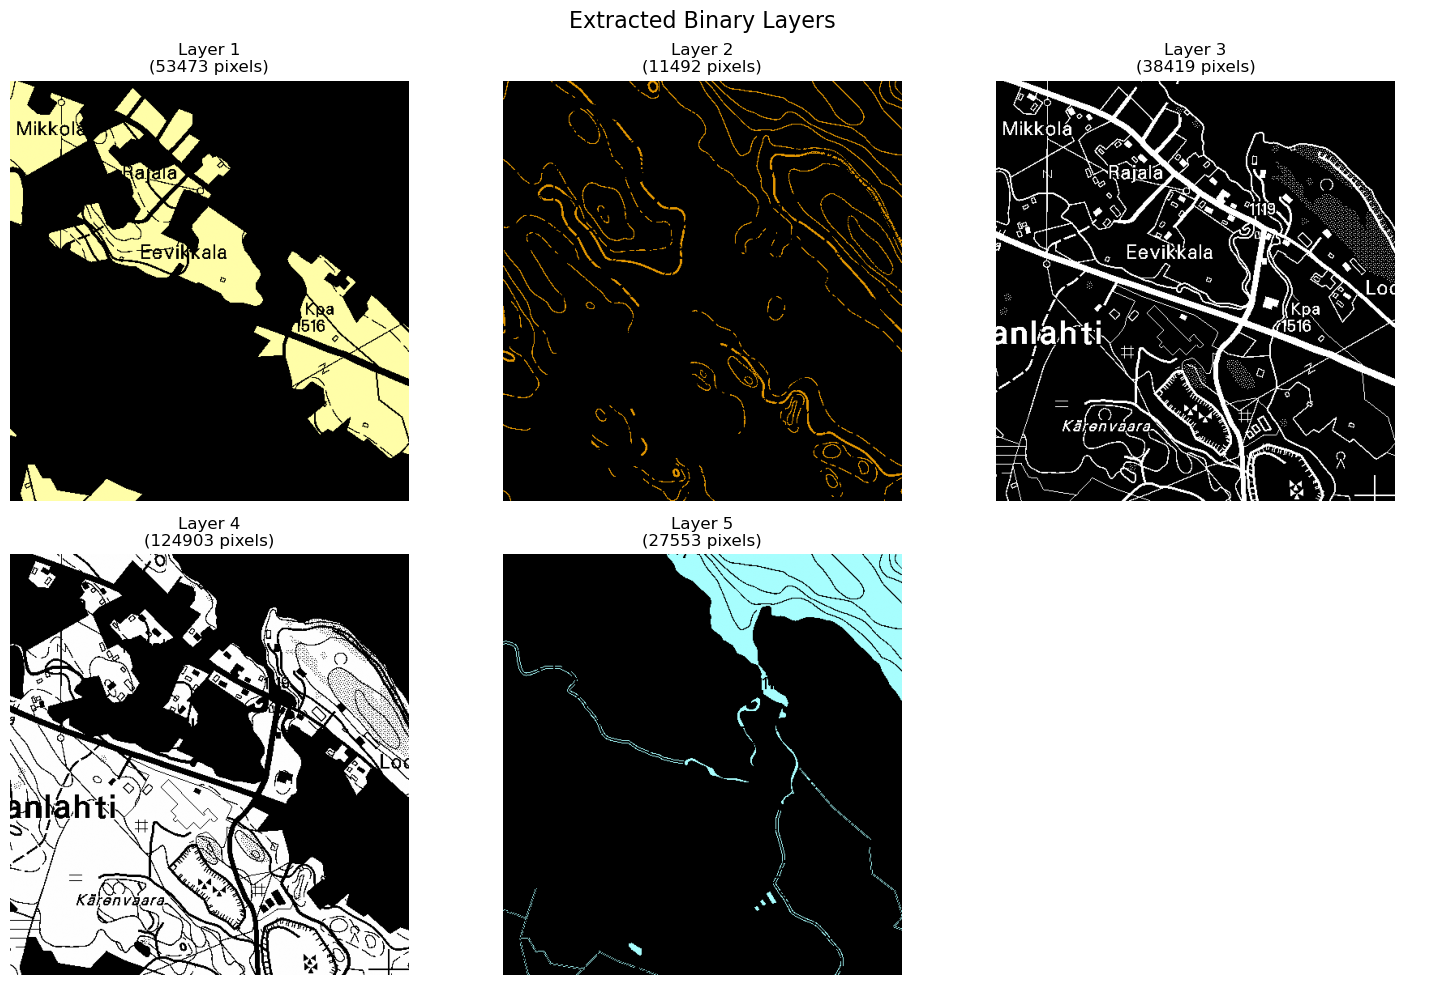

In [4]:
def extract_binary_layers(image, num_layers):
    """
    Extract binary layers from grayscale image
    
    Parameters:
    -----------
    image : numpy.ndarray
        Grayscale input image
    num_layers : int
        Number of binary layers to extract
    
    Returns:
    --------
    list : List of binary layer masks
    """
    layers = []
    
    min_val, max_val = image.min(), image.max()
    thresholds = np.linspace(min_val, max_val, num_layers + 1)
    
    for i in range(num_layers):
        lower_thresh = thresholds[i]
        upper_thresh = thresholds[i + 1]
        
        if i == num_layers - 1:
            layer_mask = (image >= lower_thresh) & (image <= upper_thresh)
        else:
            layer_mask = (image >= lower_thresh) & (image < upper_thresh)
        
        layers.append(layer_mask.astype(np.uint8))
    
    return layers

# Extract binary layers
print(f"Extracting {num_layers} binary layers ...")
binary_layers = extract_binary_layers(gray_image, num_layers)

# Display extracted layers
if num_layers <= 3:
    rows, cols = 1, num_layers
elif num_layers <= 6:
    rows, cols = 2, 3
elif num_layers <= 8:
    rows, cols = 2, 4
else:
    rows, cols = 3, (num_layers + 2) // 3

fig, axes = plt.subplots(rows, cols, figsize=figure_size)
if num_layers == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for i, layer in enumerate(binary_layers):
    layer_colored = np.zeros((*layer.shape, 3))
    
    if i == 2:
        color_hex = '#ffffff'
    else:
        color_hex = custom_colors[i] if i < len(custom_colors) else '#fefefe'
    
    color_rgb = [int(color_hex[j:j+2], 16)/255.0 for j in (1, 3, 5)]
    
    for c in range(3):
        layer_colored[:, :, c] = layer * color_rgb[c]
    
    axes[i].imshow(layer_colored)
    axes[i].set_title(f"Layer {i+1}\n({np.sum(layer)} pixels)")
    axes[i].axis('off')

for i in range(num_layers, len(axes)):
    axes[i].axis('off')

plt.suptitle("Extracted Binary Layers", fontsize=16)
plt.tight_layout()
plt.show()

## Step 2: Layer Reconstruction with Conditional Dilation

In [5]:
def conditional_dilation_reconstruction(base_layer, marker_layer, all_layers, base_idx, marker_idx, se_size=3, iterations=2):
    """
    Reconstruct base layer using conditional dilation with marker layer.
    A mask is constructed from other layers to restrict the growth of dilation and avoid overlap.
    
    Parameters:
    -----------
    base_layer : numpy.ndarray
        Layer to reconstruct (mask for conditional dilation)
    marker_layer : numpy.ndarray
        Marker layer for conditional dilation
    all_layers : list
        List of all binary layers
    base_idx : int
        Index of the base layer in all_layers
    marker_idx : int
        Index of the marker layer in all_layers
    se_size : int
        Structuring element size
    iterations : int
        Number of conditional dilation iterations
    
    Returns:
    --------
    numpy.ndarray : Final reconstructed result using conditional dilation
    """
    se = disk(se_size)
    
    # Reconstruct base layer (close small gaps)
    reconstructed_base = base_layer.copy()
    for i in range(iterations):
        reconstructed_base = binary_dilation(reconstructed_base, se)
    for i in range(iterations):
        reconstructed_base = binary_erosion(reconstructed_base, se)
    
    # Create mask from other layers to avoid overlap
    other_layers_mask = np.zeros_like(base_layer, dtype=bool)
    for i, layer in enumerate(all_layers):
        if i not in [base_idx, marker_idx]:
            other_layers_mask = np.logical_or(other_layers_mask, layer.astype(bool))
    
    fillable_area = np.logical_and(reconstructed_base.astype(bool), ~other_layers_mask)
    
    marker_features = np.logical_and(marker_layer.astype(bool), fillable_area)
    
    dilated_marker = marker_features.copy()
    for i in range(iterations):
        dilated_step = binary_dilation(dilated_marker, se)
        dilated_marker = np.logical_and(dilated_step, fillable_area)

    # Combine reconstructed base with conditional dilation result
    final_result = np.logical_or(reconstructed_base, dilated_marker).astype(np.uint8)
    
    return final_result

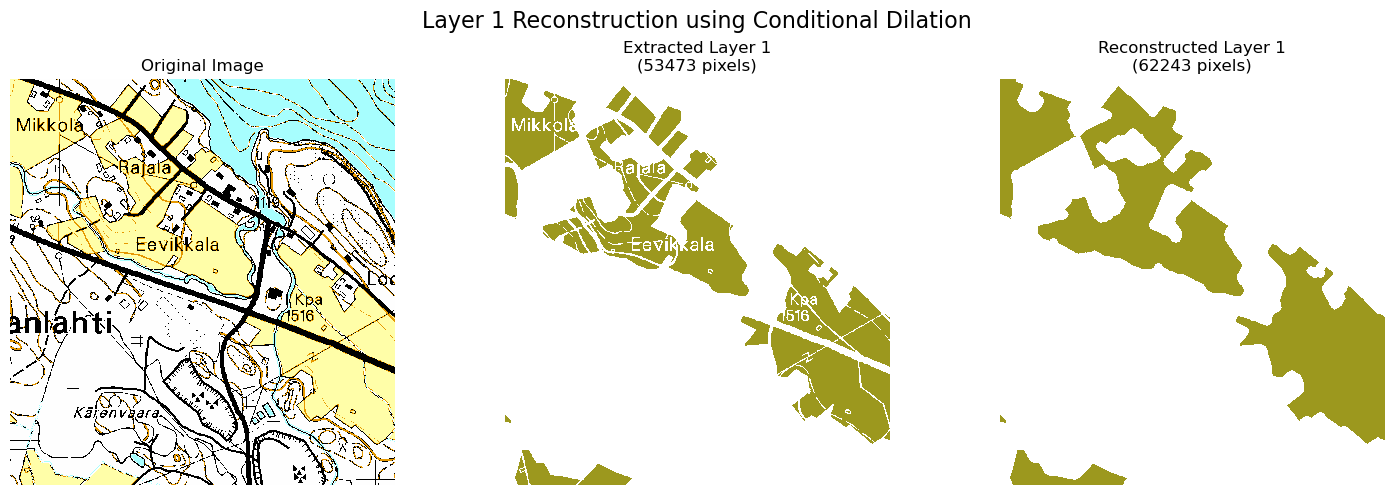

In [6]:
if num_layers >= 3:
    layer_1 = binary_layers[0]
    layer_3 = binary_layers[2]
    reconstructed1 = conditional_dilation_reconstruction(
        layer_1, layer_3, binary_layers, base_idx=0, marker_idx=2, 
        se_size=se_size, iterations=dilation_iterations
    )
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(gray_image, cmap=custom_cmap, vmin=gray_image.min(), vmax=gray_image.max())
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(binary_layers[0], cmap=binary_cmap, vmin=0, vmax=1)
    axes[1].set_title(f"Extracted Layer 1\n({np.sum(binary_layers[0])} pixels)")
    axes[1].axis('off')
    
    axes[2].imshow(reconstructed1, cmap=binary_cmap, vmin=0, vmax=1)
    axes[2].set_title(f"Reconstructed Layer 1\n({np.sum(reconstructed1)} pixels)")
    axes[2].axis('off')
    
    plt.suptitle("Layer 1 Reconstruction using Conditional Dilation", fontsize=16)
    plt.tight_layout()
    plt.show()